## KNN Temperature Classifier

     Year  Temperature  Maximum Temperature  Minimum Temperature      Class
0    1884     0.486668             0.427739             0.540732   pre_1990
1    1885     0.115661             0.075488             0.155087   pre_1990
2    1886     0.137188             0.066777             0.215384   pre_1990
3    1887     0.163737             0.204670             0.121096   pre_1990
4    1888     0.087167             0.000000             0.175246   pre_1990
..    ...          ...                  ...                  ...        ...
134  2018     0.799778             0.772874             0.805777  post_1990
135  2019     0.789299             0.740904             0.817796  post_1990
136  2020     0.868251             0.822744             0.889118  post_1990
137  2021     0.752339             0.689466             0.793153  post_1990
138  2022     1.000000             1.000000             0.968799  post_1990

[139 rows x 5 columns]
0.8928571428571429
              precision    recall  f1-score  

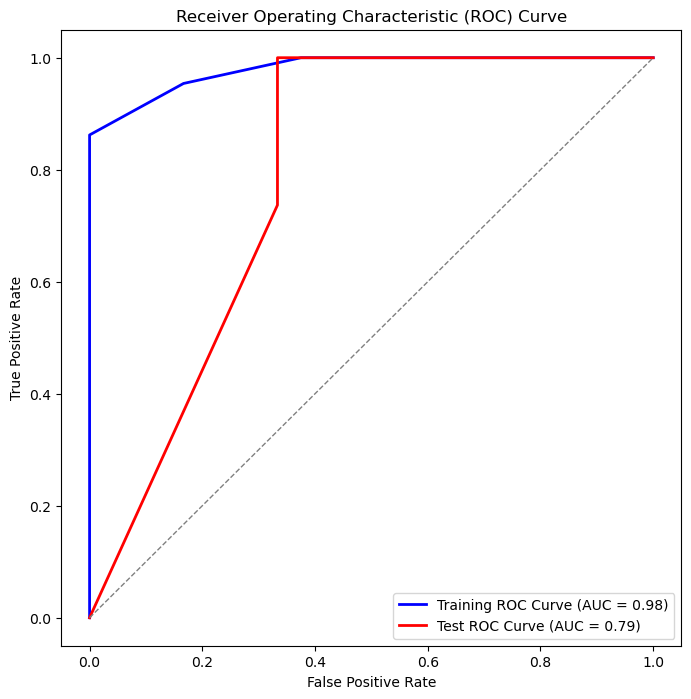

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import xarray as xr
import numpy as np
from skimage.measure import block_reduce
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder


data_temp = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Temp\*.nc", parallel=True)
data_tmax = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_tmax\*.nc", parallel=True)
data_tmin = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_tmin\*.nc", parallel=True)

temp = np.array(data_temp['tas'])
temp_max = np.array(data_tmax['tasmax'])
temp_min = np.array(data_tmin['tasmin'])
common_years = np.arange(1884, 2023)

temp_reduced = block_reduce(temp, block_size=(12, 1, 1), func=np.mean, cval=np.mean(temp))
tmax_reduced = block_reduce(temp_max, block_size=(12, 1, 1), func=np.mean, cval=np.mean(temp_max))
tmin_reduced = block_reduce(temp_min, block_size=(12, 1, 1), func=np.mean, cval=np.mean(temp_min))

temp_annual_mean = np.nanmean(temp_reduced, axis=(1, 2))
tmax_annual_mean = np.nanmean(tmax_reduced, axis=(1, 2))
tmin_annual_mean = np.nanmean(tmin_reduced, axis=(1, 2))


scaler = MinMaxScaler()
temp_annual_mean = scaler.fit_transform(temp_annual_mean.reshape(-1, 1)).flatten()
tmax_annual_mean = scaler.fit_transform(tmax_annual_mean.reshape(-1, 1)).flatten()
tmin_annual_mean = scaler.fit_transform(tmin_annual_mean.reshape(-1, 1)).flatten()

min_length = min(len(temp_annual_mean), len(tmax_annual_mean), len(tmin_annual_mean))

data_dict = {
    'Year': common_years[:min_length],
    'Temperature': temp_annual_mean[:min_length],
    'Maximum Temperature': tmax_annual_mean[:min_length],
    'Minimum Temperature': tmin_annual_mean[:min_length]}


df = pd.DataFrame(data_dict)
df['Class'] = df['Year'].apply(lambda year: 'pre_1990' if year < 1990 else 'post_1990')


print(df)

X = df[['Temperature', 'Maximum Temperature', 'Minimum Temperature']].values
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
accuracy = knn.score(X_test, y_test)
print(accuracy)
print(classification_report(y_test, y_pred))

# Training set score
train_score = knn.score(X_train, y_train)
print(f"Training Set Score: {train_score:.4f}")

# Test set score
test_score = knn.score(X_test, y_test)
print(f"Test Set Score: {test_score:.4f}")

scores = cross_val_score(knn, X, y, cv=5)  # 5-fold cross-validation
print("Average Accuracy: {:.4f}".format(scores.mean()))

le = LabelEncoder()
y_train_binary = le.fit_transform(y_train)
y_test_binary = le.transform(y_test)

# Get the predicted probabilities for the positive class for both training and test sets
y_train_prob = knn.predict_proba(X_train)[:, 1]
y_test_prob = knn.predict_proba(X_test)[:, 1]

# Compute the ROC curve for both training and test sets
fpr_train, tpr_train, thresholds_train = roc_curve(y_train_binary, y_train_prob)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test_binary, y_test_prob)

# Calculate the area under the curve (AUC) for both training and test sets
auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)

# Plot ROC curves
plt.figure(figsize=(8, 8))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Training ROC Curve (AUC = {auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC Curve (AUC = {auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## KNN Seasonal Rainfall Classifier

     Year    Winter    Spring    Summer    Autumn      Class
0    1837  0.405007  0.127659  0.443677  0.234085   pre_1990
1    1838  0.158059  0.384477  0.646413  0.316520   pre_1990
2    1839  0.224941  0.245797  0.654770  0.550416   pre_1990
3    1840  0.420432  0.090205  0.448183  0.349535   pre_1990
4    1841  0.141398  0.442522  0.594870  0.592516   pre_1990
..    ...       ...       ...       ...       ...        ...
181  2018  0.481707  0.592397  0.228384  0.439824  post_1990
182  2019  0.315974  0.625692  0.775826  0.614993  post_1990
183  2020  0.846110  0.179914  0.760059  0.557116  post_1990
184  2021  0.693294  0.566465  0.272643  0.450432  post_1990
185  2022  0.497516  0.342772  0.195403  0.723879  post_1990

[186 rows x 6 columns]
0.8035714285714286
              precision    recall  f1-score   support

   post_1990       0.38      0.33      0.35         9
    pre_1990       0.88      0.89      0.88        47

    accuracy                           0.80        56
   macr

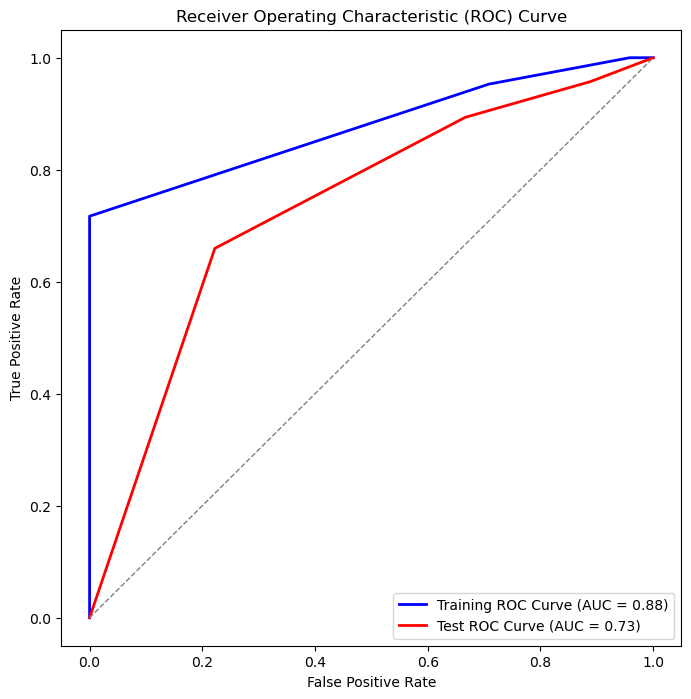

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import xarray as xr
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

data = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Season_Rain\*.nc", parallel=True)

rain = np.array(data['rainfall'])
rain = np.nanmean(rain, axis=(1, 2))

winter = rain[3::4]
spring = rain[4::4]
summer = rain[5::4]
autumn = rain[6::4]

time = np.arange(1837,2023)

winter = winter.reshape(-1, 1)
scaler = MinMaxScaler()
normalized_winter = scaler.fit_transform(winter)
winter = normalized_winter.flatten()

spring = spring.reshape(-1, 1)
normalized_spring = scaler.fit_transform(spring)
spring = normalized_spring.flatten()

summer = summer.reshape(-1, 1)
normalized_summer = scaler.fit_transform(summer)
summer = normalized_summer.flatten()

autumn = autumn.reshape(-1, 1)
normalized_autumn = scaler.fit_transform(autumn)
autumn = normalized_autumn.flatten()

data_dict = {
    'Year': time,
    'Winter': winter,
    'Spring': spring,
    'Summer': summer,
    'Autumn': autumn
}

df = pd.DataFrame(data_dict)
df['Class'] = df['Year'].apply(lambda year: 'pre_1990' if year < 1990 else 'post_1990')

print(df)

X = df[['Winter', 'Spring', 'Summer', 'Autumn']].values
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
accuracy = knn.score(X_test, y_test)
print(accuracy)
print(classification_report(y_test, y_pred))

# Training set score
train_score = knn.score(X_train, y_train)
print(f"Training Set Score: {train_score:.4f}")

# Test set score
test_score = knn.score(X_test, y_test)
print(f"Test Set Score: {test_score:.4f}")

scores = cross_val_score(knn, X, y, cv=5)  # 5-fold cross-validation
print("Average Accuracy: {:.4f}".format(scores.mean()))

le = LabelEncoder()
y_train_binary = le.fit_transform(y_train)
y_test_binary = le.transform(y_test)

# Get the predicted probabilities for the positive class for both training and test sets
y_train_prob = knn.predict_proba(X_train)[:, 1]
y_test_prob = knn.predict_proba(X_test)[:, 1]

# Compute the ROC curve for both training and test sets
fpr_train, tpr_train, thresholds_train = roc_curve(y_train_binary, y_train_prob)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test_binary, y_test_prob)

# Calculate the area under the curve (AUC) for both training and test sets
auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)

# Plot ROC curves
plt.figure(figsize=(8, 8))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Training ROC Curve (AUC = {auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC Curve (AUC = {auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Drought U.K.

In [ ]:
import xarray as xr
import numpy as np
import time
import matplotlib.pyplot as plt
import datetime as datetime

# Record start time
start_time = time.time()

data = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Day_Rain\*.nc", parallel=True)


rain = np.array(data['rainfall'])

# Set the threshold for drought
threshold = 0.2
min_consecutive_days = 15

# Initialize a list to store indices of consecutive days
consecutive_days_indices = []

# Iterate through spatial coordinates
for i in range(rain.shape[1]):
    for j in range(rain.shape[2]):
        # Iterate through time steps
        t = 0
        while t < rain.shape[0]:
            # Check if the current day has low rainfall
            if rain[t, i, j] < threshold:
                # Initialize a counter for consecutive days
                consecutive_count = 1

                # Check the following days for consecutiveness
                while consecutive_count < min_consecutive_days and t + consecutive_count < rain.shape[0]:
                    if rain[t + consecutive_count, i, j] < threshold:
                        consecutive_count += 1
                    else:
                        break

                # If consecutive days meet the criteria, store the indices
                if consecutive_count == min_consecutive_days:
                    start_timestamp = data['time'][t].values
                    end_timestamp = data['time'][t + consecutive_count - 1].values
                    consecutive_days_indices.append(((start_timestamp, end_timestamp), i, j))

                # Skip the days that were part of the consecutive sequence
                t += consecutive_count
            else:
                # Move to the next day
                t += 1

# Create a dictionary to count occurrences
location_counts = {}

# Count occurrences and record timestamps for each location
for (start_timestamp, end_timestamp), i, j in consecutive_days_indices:
    location = (i, j)
    location_counts[location] = location_counts.get(location, {'count': 0, 'timestamps': []})
    location_counts[location]['count'] += 1
    location_counts[location]['timestamps'].append((start_timestamp, end_timestamp))

# Find the most common locations and their counts
most_common_locations = sorted(location_counts.items(), key=lambda x: x[1]['count'], reverse=True)

# Top 25 most common locations
for location, info in most_common_locations[:25]:
    count = info['count']
    timestamps = info['timestamps']
    print(f"Location {location} has {count} occurrences")

# Initialize a dictionary to store occurrences per year, considering leap years
occurrences_per_year = {}

# Iterate through the list of consecutive days indices
for (start_date, end_date), i, j in consecutive_days_indices:
    # Calculate the year by considering leap years
    total_days = (start_date - np.datetime64('1891-01-01')).astype(int) + 1
    year = 1891

    # Continue until the end date is reached
    while start_date <= np.datetime64('2022-12-31'):
        total_days += 1
        start_date += np.timedelta64(1, 'D')

        # Check for a new year
        if start_date == np.datetime64(f'{year + 1}-01-01'):
            year += 1

    # Update occurrences for the extracted year
    occurrences_per_year[year] = occurrences_per_year.get(year, 0) + 1


# Extract years and corresponding occurrence counts
years = list(occurrences_per_year.keys())
occurrence_counts = list(occurrences_per_year.values())

# Print the results
for year, count in zip(years, occurrence_counts):
    print(f"Year {year} has {count} occurrences.")
    

# Plot the histogram
plt.bar(years, occurrence_counts, color='blue')
plt.xlabel('Year')
plt.ylabel('Drought Occurrences')
plt.title('Drought Occurrences per Year')
plt.savefig('Drought')

# Record end time
end_time = time.time()

# Calculate duration
duration = end_time - start_time

# Print the duration
print(f"Code execution took {duration} seconds.")

Code won't run in Jupyter.
Here is the output: 

Location (16, 43) has 215 occurrences
Location (17, 58) has 214 occurrences
Location (16, 55) has 211 occurrences
Location (16, 51) has 205 occurrences
Location (14, 42) has 204 occurrences
Location (18, 54) has 202 occurrences
Location (15, 51) has 200 occurrences
Location (16, 42) has 200 occurrences
Location (18, 66) has 200 occurrences
Location (15, 42) has 199 occurrences
Location (17, 51) has 197 occurrences
Location (17, 52) has 196 occurrences
Location (17, 64) has 193 occurrences
Location (19, 52) has 193 occurrences
Location (18, 58) has 192 occurrences
Location (19, 55) has 192 occurrences
Location (20, 54) has 191 occurrences
Location (18, 55) has 189 occurrences
Location (18, 65) has 189 occurrences
Location (24, 62) has 189 occurrences
Location (17, 50) has 188 occurrences
Location (16, 48) has 185 occurrences
Location (16, 50) has 185 occurrences
Location (24, 63) has 185 occurrences
Location (18, 61) has 184 occurrences
Code execution took 489.2613220214844 seconds.

### Exeter

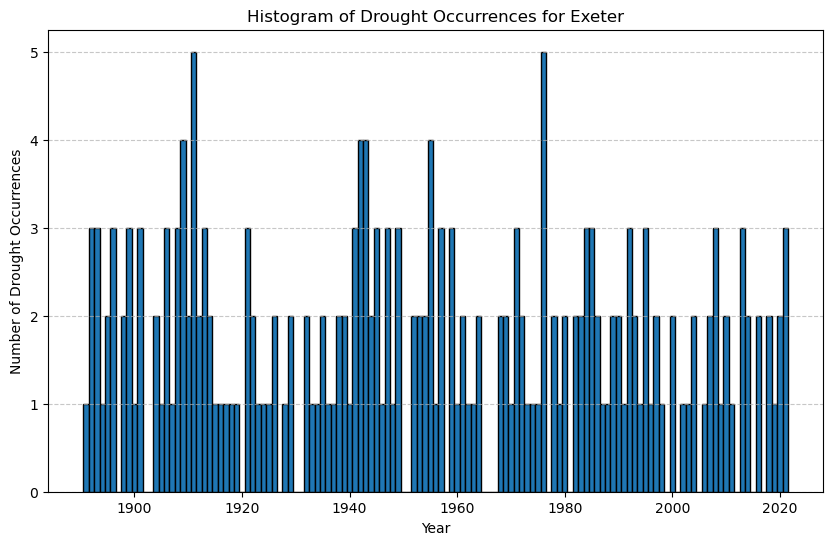

Code execution took 153.17197179794312 seconds.


In [2]:
import xarray as xr
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd

# Record start time
start_time = time.time()

data = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Day_Rain\*.nc", parallel=True)

rain = np.array(data['rainfall'])

# Set the threshold for heatwave
threshold = 0.2
min_consecutive_days = 15

# Specify the location of interest
location_of_interest = (16, 43)

# Initialize a list to store indices of consecutive days for the specific location
consecutive_days_indices_location = []

# Iterate through time steps
t = 0
while t < rain.shape[0]:
    # Check if the current day has low rainerature
    if rain[t, location_of_interest[0], location_of_interest[1]] < threshold:
        # Initialize a counter for consecutive days
        consecutive_count = 1

        # Check the following days for consecutiveness
        while consecutive_count < min_consecutive_days and t + consecutive_count < rain.shape[0]:
            if rain[t + consecutive_count, location_of_interest[0], location_of_interest[1]] < threshold:
                consecutive_count += 1
            else:
                break

        # If consecutive days meet the criteria, store the indices
        if consecutive_count == min_consecutive_days:
            start_timestamp = data['time'][t].values
            end_timestamp = data['time'][t + consecutive_count - 1].values
            consecutive_days_indices_location.append(((start_timestamp, end_timestamp), *location_of_interest))

        # Skip the days that were part of the consecutive sequence
        t += consecutive_count
    else:
        # Move to the next day
        t += 1


# Extract year information from timestamps
years_location = [pd.to_datetime(start).year for (start, end), _, _ in consecutive_days_indices_location]

# Create a histogram for the specific location
plt.figure(figsize=(10, 6))
plt.hist(years_location, bins=range(min(years_location), max(years_location) + 1), edgecolor='black', align='left')
plt.xlabel('Year')
plt.ylabel('Number of Drought Occurrences')
plt.title('Histogram of Drought Occurrences for Exeter')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Record end time
end_time = time.time()

# Calculate duration
duration = end_time - start_time

# Print the duration
print(f"Code execution took {duration} seconds.")

## Heatwave U.K.

In [ ]:
import xarray as xr
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd

# Record start time
start_time = time.time()

data = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Day_tmax\*.nc", parallel=True)


temp = np.array(data['tasmax'])

# Set the threshold for heatwave
threshold = 28
min_consecutive_days = 3

# Initialize a list to store indices of consecutive days
consecutive_days_indices = []

# Iterate through spatial coordinates
for i in range(temp.shape[1]):
    for j in range(temp.shape[2]):
        # Iterate through time steps
        t = 0
        while t < temp.shape[0]:
            # Check if the current day has low tempfall
            if temp[t, i, j] > threshold:
                # Initialize a counter for consecutive days
                consecutive_count = 1

                # Check the following days for consecutiveness
                while consecutive_count < min_consecutive_days and t + consecutive_count < temp.shape[0]:
                    if temp[t + consecutive_count, i, j] > threshold:
                        consecutive_count += 1
                    else:
                        break

                # If consecutive days meet the criteria, store the indices
                if consecutive_count == min_consecutive_days:
                    start_timestamp = data['time'][t].values
                    end_timestamp = data['time'][t + consecutive_count - 1].values
                    consecutive_days_indices.append(((start_timestamp, end_timestamp), i, j))

                # Skip the days that were part of the consecutive sequence
                t += consecutive_count
            else:
                # Move to the next day
                t += 1

# Create a dictionary to count occurrences
location_counts = {}

# Count occurrences and record timestamps for each location
for (start_timestamp, end_timestamp), i, j in consecutive_days_indices:
    location = (i, j)
    location_counts[location] = location_counts.get(location, {'count': 0, 'timestamps': []})
    location_counts[location]['count'] += 1
    location_counts[location]['timestamps'].append((start_timestamp, end_timestamp))

# Find the most common locations and their counts
most_common_locations = sorted(location_counts.items(), key=lambda x: x[1]['count'], reverse=True)

# Top 25 most common locations
for location, info in most_common_locations[:25]:
    count = info['count']
    timestamps = info['timestamps']
    print(f"Location {location} has {count} occurrences")

# Extract year information from timestamps
years = [pd.to_datetime(start).year for (start, end), _, _ in consecutive_days_indices]

# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(years, bins=range(min(years), max(years) + 1), edgecolor='black', align='left')
plt.xlabel('Year')
plt.ylabel('Number of Heatwave Occurrences')
plt.title('Histogram of Heatwave Occurrences per Year')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Record end time
end_time = time.time()

# Calculate duration
duration = end_time - start_time

# Print the duration
print(f"Code execution took {duration} seconds.")


Location (24, 62) has 64 occurrences
Location (23, 60) has 62 occurrences
Location (23, 61) has 62 occurrences
Location (30, 63) has 62 occurrences
Location (23, 62) has 61 occurrences
Location (24, 60) has 61 occurrences
Location (24, 61) has 60 occurrences
Location (24, 63) has 60 occurrences
Location (22, 60) has 58 occurrences
Location (31, 62) has 57 occurrences
Location (23, 58) has 56 occurrences
Location (29, 62) has 56 occurrences
Location (30, 62) has 56 occurrences
Location (23, 59) has 55 occurrences
Location (25, 55) has 55 occurrences
Location (29, 61) has 55 occurrences
Location (29, 63) has 55 occurrences
Location (31, 63) has 55 occurrences
Location (22, 59) has 54 occurrences
Location (26, 55) has 54 occurrences
Location (30, 61) has 54 occurrences
Location (22, 61) has 53 occurrences
Location (23, 57) has 53 occurrences
Location (25, 54) has 53 occurrences
Location (25, 56) has 53 occurrences
Code execution took 180.73660373687744 seconds.

### London

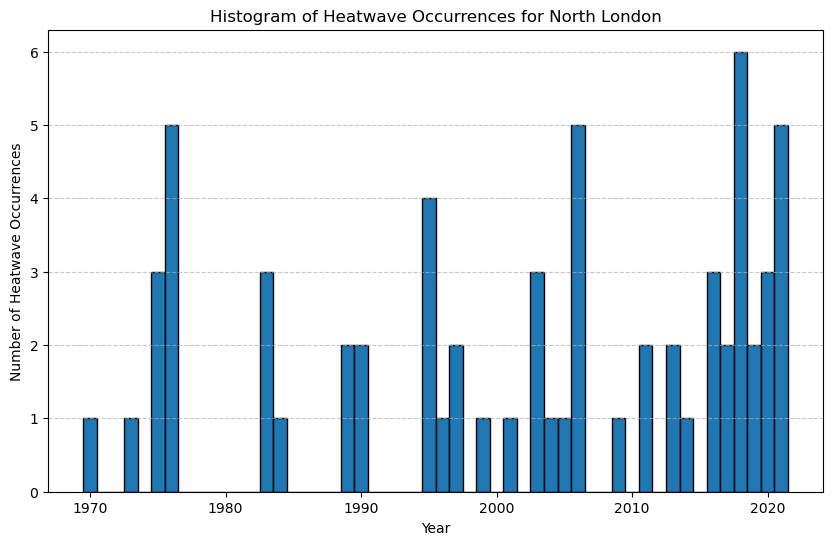

Code execution took 48.356215476989746 seconds.


In [2]:
import xarray as xr
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd

# Record start time
start_time = time.time()

data = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Day_tmax\*.nc", parallel=True)

temp = np.array(data['tasmax'])

# Set the threshold for heatwave
threshold = 28
min_consecutive_days = 3

# Specify the location of interest
location_of_interest = (24, 62)

# Initialize a list to store indices of consecutive days for the specific location
consecutive_days_indices_location = []

# Iterate through time steps
t = 0
while t < temp.shape[0]:
    # Check if the current day has low temperature
    if temp[t, location_of_interest[0], location_of_interest[1]] > threshold:
        # Initialize a counter for consecutive days
        consecutive_count = 1

        # Check the following days for consecutiveness
        while consecutive_count < min_consecutive_days and t + consecutive_count < temp.shape[0]:
            if temp[t + consecutive_count, location_of_interest[0], location_of_interest[1]] > threshold:
                consecutive_count += 1
            else:
                break

        # If consecutive days meet the criteria, store the indices
        if consecutive_count == min_consecutive_days:
            start_timestamp = data['time'][t].values
            end_timestamp = data['time'][t + consecutive_count - 1].values
            consecutive_days_indices_location.append(((start_timestamp, end_timestamp), *location_of_interest))

        # Skip the days that were part of the consecutive sequence
        t += consecutive_count
    else:
        # Move to the next day
        t += 1


# Extract year information from timestamps
years_location = [pd.to_datetime(start).year for (start, end), _, _ in consecutive_days_indices_location]

# Create a histogram for the specific location
plt.figure(figsize=(10, 6))
plt.hist(years_location, bins=range(min(years_location), max(years_location) + 1), edgecolor='black', align='left')
plt.xlabel('Year')
plt.ylabel('Number of Heatwave Occurrences')
plt.title('Histogram of Heatwave Occurrences for North London')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Record end time
end_time = time.time()

# Calculate duration
duration = end_time - start_time

# Print the duration
print(f"Code execution took {duration} seconds.")



## Tropical Nights

Location (24, 62) has 11 occurrences
Location (23, 60) has 10 occurrences
Location (23, 61) has 8 occurrences
Location (18, 66) has 7 occurrences
Location (23, 62) has 7 occurrences
Location (22, 68) has 6 occurrences
Location (20, 68) has 4 occurrences
Location (20, 69) has 4 occurrences
Location (21, 68) has 4 occurrences
Location (22, 67) has 4 occurrences
Location (23, 66) has 4 occurrences
Location (24, 60) has 4 occurrences
Location (24, 63) has 4 occurrences
Location (27, 69) has 4 occurrences
Location (17, 64) has 3 occurrences
Location (19, 68) has 3 occurrences
Location (21, 70) has 3 occurrences
Location (22, 69) has 3 occurrences
Location (24, 61) has 3 occurrences
Location (24, 66) has 3 occurrences
Location (25, 57) has 3 occurrences
Location (25, 58) has 3 occurrences
Location (25, 67) has 3 occurrences
Location (27, 50) has 3 occurrences
Location (31, 65) has 3 occurrences


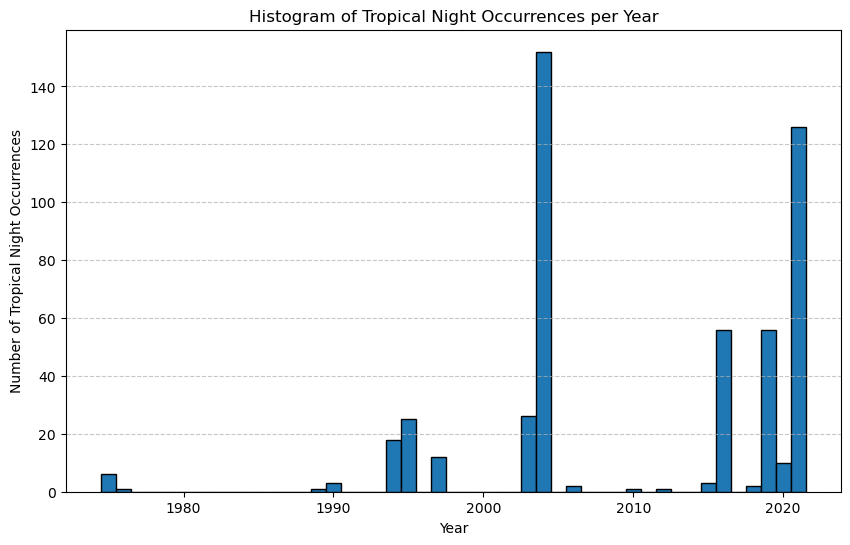

Code execution took 197.62658667564392 seconds.


In [3]:
import xarray as xr
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd

# Record start time
start_time = time.time()

data = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Day_tmin\*.nc", parallel=True)

temp = np.array(data['tasmin'])

# Set the threshold for heatwave
threshold = 20
min_consecutive_days = 1

# Initialize a list to store indices of consecutive days
consecutive_days_indices = []

# Iterate through spatial coordinates
for i in range(temp.shape[1]):
    for j in range(temp.shape[2]):
        # Iterate through time steps
        t = 0
        while t < temp.shape[0]:
            # Check if the current day has low tempfall
            if temp[t, i, j] > threshold:
                # Initialize a counter for consecutive days
                consecutive_count = 1

                # Check the following days for consecutiveness
                while consecutive_count < min_consecutive_days and t + consecutive_count < temp.shape[0]:
                    if temp[t + consecutive_count, i, j] > threshold:
                        consecutive_count += 1
                    else:
                        break

                # If consecutive days meet the criteria, store the indices
                if consecutive_count == min_consecutive_days:
                    start_timestamp = data['time'][t].values
                    end_timestamp = data['time'][t + consecutive_count - 1].values
                    consecutive_days_indices.append(((start_timestamp, end_timestamp), i, j))

                # Skip the days that were part of the consecutive sequence
                t += consecutive_count
            else:
                # Move to the next day
                t += 1

# Create a dictionary to count occurrences
location_counts = {}

# Count occurrences and record timestamps for each location
for (start_timestamp, end_timestamp), i, j in consecutive_days_indices:
    location = (i, j)
    location_counts[location] = location_counts.get(location, {'count': 0, 'timestamps': []})
    location_counts[location]['count'] += 1
    location_counts[location]['timestamps'].append((start_timestamp, end_timestamp))

# Find the most common locations and their counts
most_common_locations = sorted(location_counts.items(), key=lambda x: x[1]['count'], reverse=True)

# Top 25 most common locations
for location, info in most_common_locations[:25]:
    count = info['count']
    timestamps = info['timestamps']
    print(f"Location {location} has {count} occurrences")

# Extract year information from timestamps
years = [pd.to_datetime(start).year for (start, end), _, _ in consecutive_days_indices]

# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(years, bins=range(min(years), max(years) + 1), edgecolor='black', align='left')
plt.xlabel('Year')
plt.ylabel('Number of Tropical Night Occurrences')
plt.title('Histogram of Tropical Night Occurrences per Year')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Record end time
end_time = time.time()

# Calculate duration
duration = end_time - start_time

# Print the duration
print(f"Code execution took {duration} seconds.") 

### North London

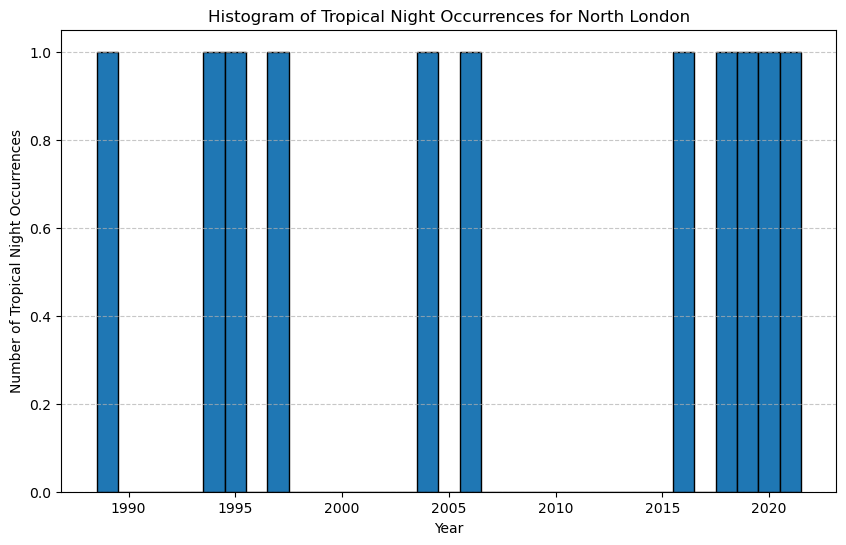

Code execution took 56.287384271621704 seconds.


In [2]:
import xarray as xr
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd

# Record start time
start_time = time.time()

data = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Day_tmin\*.nc", parallel=True)

temp = np.array(data['tasmin'])

# Set the threshold for heatwave
threshold = 20

# Specify the location of interest
location_of_interest = (24, 62)

# Initialize a list to store timestamps of days above the threshold for the specific location
above_threshold_timestamps = []

# Iterate through time steps
for t in range(temp.shape[0]):
    # Check if the temperature is above the threshold for the given location
    if temp[t, location_of_interest[0], location_of_interest[1]] > threshold:
        above_threshold_timestamps.append(data['time'][t].values)

# Extract year information from timestamps
years_location = [pd.to_datetime(timestamp).year for timestamp in above_threshold_timestamps]

# Create a histogram for the specific location
plt.figure(figsize=(10, 6))
plt.hist(years_location, bins=range(min(years_location), max(years_location) + 1), edgecolor='black', align='left')
plt.xlabel('Year')
plt.ylabel('Number of Tropical Night Occurrences')
plt.title('Histogram of Tropical Night Occurrences for North London')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Record end time
end_time = time.time()

# Calculate duration
duration = end_time - start_time

# Print the duration
print(f"Code execution took {duration} seconds.")

## Interesting Aside

### Met Office Predictions

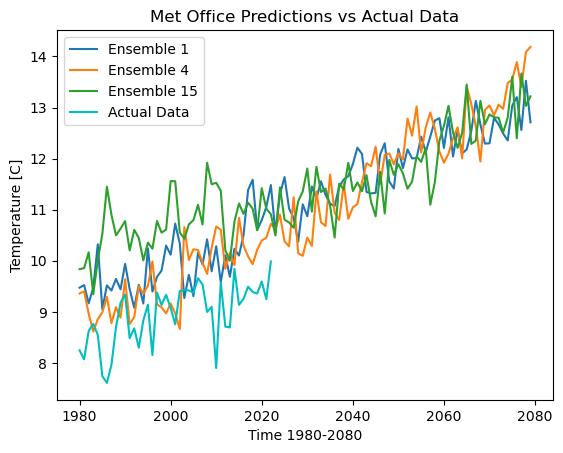

In [1]:
import xarray as xr
import numpy as np
from skimage.measure import block_reduce
import matplotlib.pyplot as plt

data = xr.open_dataset(r"C:\Users\iarla\Downloads\tas_rcp85_land-rcm_uk_12km_01_mon_198012-208011.nc")
data1 = xr.open_dataset(r"C:\Users\iarla\Downloads\tas_rcp85_land-rcm_uk_12km_04_mon_198012-208011.nc")
data2 = xr.open_dataset(r"C:\Users\iarla\Downloads\tas_rcp85_land-rcm_uk_12km_15_mon_198012-208011.nc")
data3 = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Temp\*.nc", parallel=True)

temp = np.array(data["tas"])
temp = temp[0,:,:,:]

temp1 = np.array(data1["tas"])
temp1 = temp1[0,:,:,:]

temp2 = np.array(data2["tas"])
temp2 = temp2[0,:,:,:]

temp3 = np.array(data3["tas"])


temp = block_reduce(temp, block_size=(12, 1, 1), func=np.mean, cval=np.mean(temp))
temp = np.mean(temp, axis=(1,2))

temp1 = block_reduce(temp1, block_size=(12, 1, 1), func=np.mean, cval=np.mean(temp1))
temp1 = np.mean(temp1, axis=(1,2))

temp2 = block_reduce(temp2, block_size=(12, 1, 1), func=np.mean, cval=np.mean(temp2))
temp2 = np.mean(temp2, axis=(1,2))

temp3 = block_reduce(temp3, block_size=(12, 1, 1), func=np.mean, cval=np.mean(temp3))
temp3 = temp3[96:,:,:]
temp3 = np.nanmean(temp3, axis=(1,2))


time = np.arange(1980,2080)
time1 = np.arange(1980,2023)

plt.plot(time,temp, label='Ensemble 1')
plt.plot(time,temp1, label='Ensemble 4')
plt.plot(time,temp2, label='Ensemble 15')
plt.plot(time1,temp3, 'c', label='Actual Data')
plt.xlabel('Time 1980-2080')
plt.ylabel('Temperature [C]')
plt.title('Met Office Predictions vs Actual Data')
plt.legend()